In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import ngene as ng
import ccgpack as ccg
import tensorflow as tf
from tqdm import tqdm, trange
from scipy.stats import ttest_ind

/home/gf/packages/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cl = np.load('./cl_planck_lensed.npy')
sfs = ccg.StochasticFieldSimulator(cl)
size = 7.2

In [3]:
# alpha = 1

# fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

# num = 400
# imgx = np.zeros((num, num), dtype=np.double)
# imgy = np.zeros((num, num), dtype=np.double)

# begins = ccg.random_inside(imgx,num=50)
# ends = ccg.random_inside(imgx,num=50)

# g = sfs.simulate(num,size)
# g -= g.min()
# g /= g.max()    
# s = ccg.draw_line(imgx,begins=begins,ends=ends,value=1)

# imgx = g+alpha*s
# imgy = s

# ax1.imshow(imgx)
# ax1.axis('off')
# ax2.imshow(imgy)
# ax2.axis('off')

In [3]:
def pdf(m,bins=20):
    m = np.array(m)
    hist, bin_edges = np.histogram(m, bins)
    bins = 0.5*(bin_edges[1:]+bin_edges[:1])
    return bins,hist

class DataProvider(object):
    
    def __init__(self,nside,size,alpha,num,n_buffer=200,reinit=1000):
        
        self.nside = nside
        self.alpha = alpha
        self.num = num
        self.size = size
        self.n_buffer = n_buffer
        self.reinit = reinit
        self.couter = 0
        
    def simulate(self):
        
        s = np.zeros((self.nside, self.nside), dtype=np.double)
        begins = ccg.random_inside(s,num=self.num)
        ends = ccg.random_inside(s,num=self.num)

        g = sfs.simulate(self.nside,self.size)
        g -= g.min()
        g /= g.max()    
        s = ccg.draw_line(s,begins=begins,ends=ends,value=1)

        return g,s
    
    def simulation_initiation(self):
        gs = []
        ss = []    
#         for i in tqdm(range(self.n_buffer), total=self.n_buffer, unit=" map", desc='Initiation', ncols=70):
        for i in range(self.n_buffer):
            g,s = self.simulate()
            gs.append(g)
            ss.append(s)
        return np.array(gs),np.array(ss)
        
    def __call__(self,n):
        
        if self.couter%self.reinit==0:
            self.gs, self.ss = self.simulation_initiation()
        self.couter += 1
        x_out = []
        y_out = []
        for i in range(n):
            i_g,i_s = np.random.randint(0,self.n_buffer,2)
            x_out.append(self.gs[i_g]+self.alpha*self.ss[i_s])
            y_out.append(self.ss[i_s])
            
        x_out = np.array(x_out)
        y_out = np.array(y_out)
        return np.expand_dims(x_out,-1),np.expand_dims(y_out,-1)
        

In [5]:
nside=400
dp = DataProvider(nside=nside,size=7,alpha=0.7,num=50)
dp0 = DataProvider(nside=nside,size=7,alpha=0,num=50,n_buffer=100)
x,y = dp0(1)
x,y = dp(1)

(-0.5, 399.5, 399.5, -0.5)

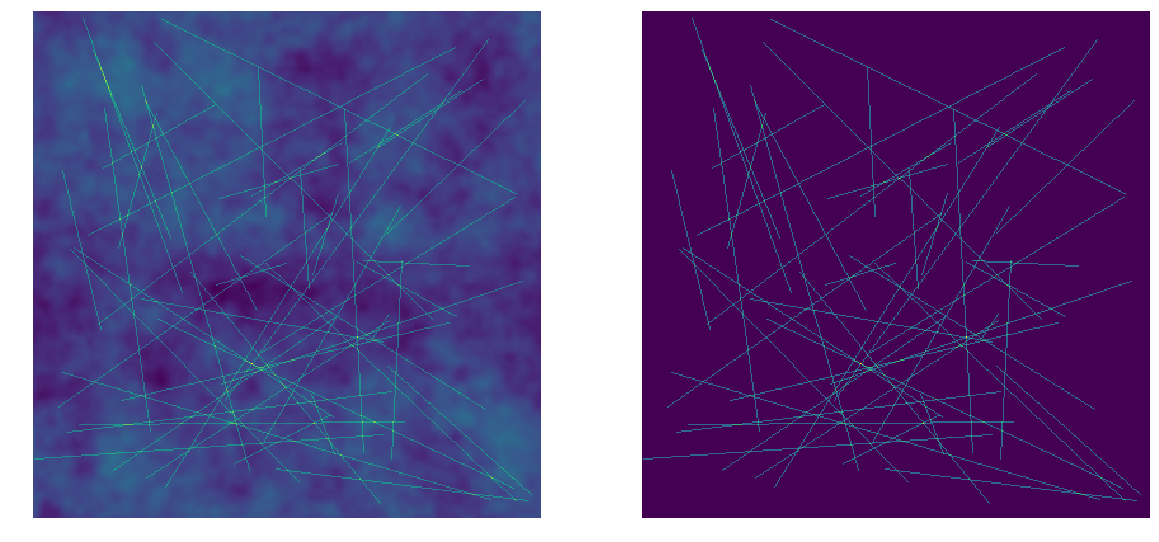

In [6]:
fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

ax1.imshow(x[0,:,:,0])
ax1.axis('off')
ax2.imshow(y[0,:,:,0])
ax2.axis('off')

In [11]:
def architecture(x_in):

    initzer = tf.contrib.layers.xavier_initializer()
    # initzer = tf.contrib.layers.variance_scaling_initializer()
    x = tf.layers.conv2d(x_in,filters=12,
                        kernel_size=5,
                        padding='SAME',
                        kernel_initializer=initzer,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.05),
                        bias_initializer=tf.constant_initializer(0.1),
                        name='conv_1')
    x = tf.layers.batch_normalization(x,name='norm_1')
    x = tf.nn.relu(x,name='act_1')

    x = tf.layers.conv2d(x,filters=12,
                        kernel_size=5,
                        padding='SAME',
                        kernel_initializer=initzer,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.05),
                        bias_initializer=tf.constant_initializer(0.1),
                        name='conv_2')
    x = tf.layers.batch_normalization(x,name='norm_2')
    x = tf.nn.relu(x,name='act_2')

    x = tf.layers.conv2d(x,filters=1,
                        kernel_size=5,
                        padding='SAME',
                        kernel_initializer=initzer,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.05),
                        bias_initializer=tf.constant_initializer(0.1),
                        name='conv_3')
    x = tf.layers.batch_normalization(x,name='norm_3')
    x_out = tf.nn.relu(x,name='act_3')
    return x_out

def check():
    l0 = []
    l1 = []
    for i in range(100):
        x,y = dp(1)
        x0,y = dp0(1)`b
        l0.append(model.conv(x0).std())
        l1.append(model.conv(x).std())
    b0,h0 = pdf(l0,20)
    b1,h1 = pdf(l1,20)
    plt.plot(b0,h0)
    plt.plot(b1,h1)
    print('p-value:',ttest_ind(l0,l1)[1])
    return ttest_ind(l0,l1)[1]

In [ ]:
model = ng.Model(nx=nside,ny=nside,n_channel=1,n_class=1,
         restore=0,model_add='./model',arch=architecture)

print('# of variables:',model.n_variables)

In [59]:
dp.alpha = dp.alpha-0.02

In [60]:
dp.alpha

0.08000000000000002

Epoch:0, cost= 93364.145312
Epoch:1, cost= 99424.750781
Epoch:2, cost= 99792.332031
Epoch:3, cost= 98401.047656
Epoch:4, cost= 99638.731250
Epoch:5, cost= 101716.519531
Epoch:6, cost= 100533.714844
Epoch:7, cost= 99952.504687
Epoch:8, cost= 99135.102344
Epoch:9, cost= 100345.900000
p-value: 0.31568349289469516


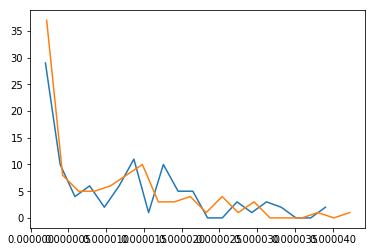

In [72]:
model.train(data_provider=dp,training_epochs = 10,iterations=10 ,n_s = 10,
                    learning_rate = 0.01, time_limit=None,
                    metric=None, verbose=1,death_preliminary_check = 30,
                    death_frequency_check = 1000)
pv = check()

Text(0.5,1,'Prediction')

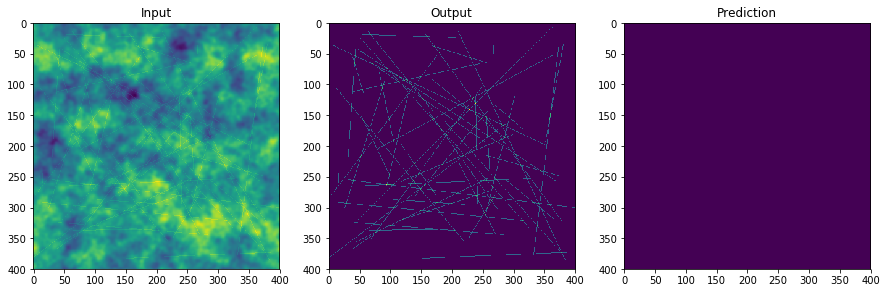

In [74]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(15,7))

x,y = dp(1)
x_pred = model.conv(x)

ax1.imshow(x[0,:,:,0])
ax1.set_title('Input')
ax2.imshow(y[0,:,:,0])
ax2.set_title('Output')
ax3.imshow(x_pred[:,:,0])
ax3.set_title('Prediction')

In [11]:
dalpha = 0.1
p_move = 0

for i in range(50):

    model.train(data_provider=dp,training_epochs = 10,iterations=10 ,n_s = 10,
                        learning_rate = 0.01, time_limit=None,
                        metric=None, verbose=1,death_preliminary_check = 30,
                        death_frequency_check = 1000)
    pv = check()
    if pv<0.003:
        if p_move == 1:
            dalpha = dalpha/2
        dp.alpha = dp.alpha-dalpha
        p_move = -1
    else:
        if p_move == -1:
            dalpha = dalpha/2
        dp.alpha = dp.alpha+dalpha
        p_move = 1

Warning! Dead model! Reinitiating...
Epoch:0, cost= 13566615.285156
Epoch:1, cost= 101572.792969
Epoch:2, cost= 102103.878125
Epoch:3, cost= 101314.185938
Epoch:4, cost= 100387.688281
Epoch:5, cost= 102200.181250
Epoch:6, cost= 102848.192969
Epoch:7, cost= 101605.171875
Epoch:8, cost= 100693.097656


Initiation:   0%|                           | 0/100 [00:00<?, ? map/s]

Epoch:9, cost= 100552.900000


Initiation: 100%|█████████████████| 100/100 [00:12<00:00,  8.45 map/s]


Epoch:0, cost= 100364.287500
Epoch:1, cost= 100158.394531
Epoch:2, cost= 101617.035156
Warning! Dead model! Reinitiating...
Epoch:3, cost= 10737669.406250
Epoch:4, cost= 90912.507031
Epoch:5, cost= 105232.314062
Epoch:6, cost= 60912.644922
Epoch:7, cost= 41258.440820
Epoch:8, cost= 20339.392676
Epoch:9, cost= 13722.296777
Epoch:0, cost= 11401.406445
Epoch:1, cost= 15839.912500
Epoch:2, cost= 10244.528809
Epoch:3, cost= 164971.037695
Epoch:4, cost= 101366.911719
Epoch:5, cost= 100435.023438
Epoch:6, cost= 155185.035156
Epoch:7, cost= 49625.679590
Epoch:8, cost= 12579.955176
Epoch:9, cost= 11667.891699
Epoch:0, cost= 24110.834961
Epoch:1, cost= 7855.210986
Epoch:2, cost= 46663.421582
Warning! Dead model! Reinitiating...
Warning! Dead model! Reinitiating...
Warning! Dead model! Reinitiating...
Epoch:3, cost= 1480052.813281
Epoch:4, cost= 7474137.739063
Epoch:5, cost= 97667.791406
Epoch:6, cost= 91824.030469
Epoch:7, cost= 82154.583594
Epoch:8, cost= 71258.800781
Epoch:9, cost= 51260.37773

Initiation:  78%|█████████████▎   | 156/200 [00:15<00:04, 10.30 map/s]

KeyboardInterrupt: 

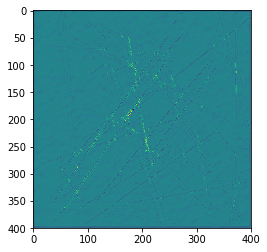

In [28]:
plt.imshow(np.squeeze(y)-np.squeeze(x_pred))

In [29]:

def check():
    l0 = []
    l1 = []

    for i in range(100):
        x,y = dp(1)
        x0,y = dp0(1)
        l0.append(model.conv(x0).std())
        l1.append(model.conv(x).std())

#     b0,h0 = pdf(l0,20)
#     b1,h1 = pdf(l1,20)
#     plt.plot(b0,h0)
#     plt.plot(b1,h1)
#     print('p-value:',ttest_ind(l0,l1)[1])
    return ttest_ind(l0,l1)[1]

Initiation: 100%|█████████████████| 200/200 [00:18<00:00, 10.89 map/s]


p-value: 6.64705388618376e-264


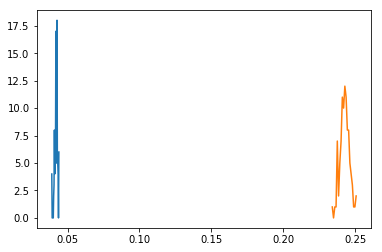

In [30]:


b0,h0 = pdf(l0,20)
b1,h1 = pdf(l1,20)
plt.plot(b0,h0)
plt.plot(b1,h1)
print('p-value:',ttest_ind(l0,l1)[1])